### Template Supermarket model


In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt, patches
import scipy.stats as ss
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot


Model design

In [2]:
# Config
# ticks = 3600 # 3600 ticks = 3600 seconds = 1 hour
ticks = 21600 # 3600 ticks = 3600 seconds = 6 hour
no_customers = 500
no_counters = 5
avg_service_time = 45 # ticks/seconds per customer
gross_margin_per_customer = 10 # dollars
cost_per_counter = 300 # dollars

In [3]:
def get_customers_arrived(model):
    customers_arrived = [customer._arrived for customer in model.customers]
    no_customers_arrived = np.sum(customers_arrived)
    return no_customers_arrived


def get_customers_served(model):
    customers_served = [not(customer._service_exit is None)
                        for customer in model.customers]
    no_customers_served = np.sum(customers_served)
    return no_customers_served


def get_customers_balked(model):
    customers_arrived = [customer._arrived for customer in model.customers]
    # Customers who never joined a queue
    customers_no_q = np.array(
        [customer._q_entry is None for customer in model.customers])
    no_customers_balked = np.sum(customers_arrived * customers_no_q)
    return no_customers_balked


def get_avg_queue_size(model):
    queue_size = [len(counter.queue) for counter in model.counters]
    avg_queue_size = np.mean(queue_size)
    return avg_queue_size


def get_avg_waiting_time(model):
    customers_wait = [np.nan if customer._q_exit is None else
                      customer._q_exit - customer._q_entry for customer in model.customers]
    avg_customer_wait = np.nanmean(customers_wait)
    return avg_customer_wait


def get_gross_margin(model):
    return gross_margin_per_customer * get_customers_served(model)


def get_operating_costs(model):
    return cost_per_counter * no_counters


def get_total_profit(model):
    return get_gross_margin(model) - get_operating_costs(model)


In [4]:
# no_customers
# a = ss.poisson(45).rvs()
# print(a)
# mu = 0.6
# mean, var, skew, kurt = ss.poisson.stats(mu, moments='mvsk')
# print(var)
# a = ss.poisson(45).rvs(15, loc=5, size=1, random_state=None)
a = ss.poisson.rvs(15, loc=5, random_state=None)
print(a)

23


In [5]:
class Customer(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Time for customer shopping
        self.shopping_time = ss.poisson(45).rvs() 
        # self._shopping_entry
        # Time required to process the customer's transaction
        self.service_time = ss.poisson(45).rvs()
        self.shopping_time = ss.poisson(45).rvs()
        # Time of arrival at queue
        self.entry_time = (np.int(ss.beta(3, 3).rvs() * ticks) + 1) + self.shopping_time
        self.balk_tolerance = ss.poisson(5).rvs() + 1
        # # Shopping
        # self._shopping_entry = None
        # self._shopping_exit = None
        # self._enter_store = False
        # Time of entry and exit into the Store 
        self._shop_start = None
        self._shop_stop = None
        # Whether or not the customer has arrived at the queue
        self._arrived = False
        self._chosen_counter = None
        self._q_entry = None
        self._q_exit = None
        # Start time when customer is being served
        self._service_entry = None
        # End time
        self._service_exit = None
    def go_shopping(self):
        self._enter_store = True
        # self._shopping_entry
        self.model._ #current time + shopping time, then set as model time for passing into queue
    def select_counter(self):
        self._arrived = True
        # Queue at shortest counter
        self._chosen_counter_idx = np.argmin([
            len(counter.queue) for counter in self.model.counters])
        self._chosen_counter = self.model.counters[self._chosen_counter_idx]
        # Balk if there are too many people at the counter
        if len(self._chosen_counter.queue) < self.balk_tolerance:
            self._chosen_counter.queue.append(self)
            self._q_entry = self.model._current_tick
        # elif self.select_counter(self,new=yes)
    
    def select_counter(self): #modified
        self._arrived = True
        # Queue at shortest counter
        self._chosen_counter_idx = np.argmin([
            len(counter.queue) for counter in self.model.counters])
        self._chosen_counter = self.model.counters[self._chosen_counter_idx]
        # Balk if there are too many people at the counter
        if len(self._chosen_counter.queue) < self.balk_tolerance:
            self._chosen_counter.queue.append(self)
            self._q_entry = self.model._current_tick
        # elif self.select_counter(self,new=yes)

    def pay_n_leave(self):
        self._service_exit = self.model._current_tick
        self._chosen_counter.active_customer = None

    def step(self):
        # if (self._enter_store == False) & (self.model._current_tick >= self._shop_start):
        #     self.go_shopping(self)
        if (self._arrived == False) & (self.model._current_tick >= self.entry_time):
            self.select_counter()
        elif isinstance(self._service_entry, int):
            if self.model._current_tick - self._service_entry == self.service_time:
                self.pay_n_leave()


class Counter(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.queue = []
        self.active_customer = None
        self.entry_time = np.int(ss.uniform().rvs() * ticks) + 1

    def dequeue(self):
        try:
            self.active_customer = self.queue.pop(0)
            self.active_customer._service_entry = self.model._current_tick
            self.active_customer._q_exit = self.model._current_tick
        except:
            pass

    def step(self):
        if self.active_customer is None:
            self.dequeue()
        # if 
    if len(self.Counter.queue) > 5:
        self.shedule.add(counter)
        self.counters.append(counter)

class SMarket(Model):
    """Queueing model with customers and counters as two
    types of agents that interact with each other
    """

    def __init__(self, no_customers, no_counters, ticks):
        self.ticks = ticks
        self._current_tick = 1
        self.no_customers = no_customers
        self.no_counters = no_counters
        self.schedule = RandomActivation(self)
        # Create agents
        self.customers = []
        self.counters = []
        for i in range(self.no_customers):
            customer = Customer(i, self)
            self.schedule.add(customer)
            self.customers.append(customer)
        for i in range(self.no_counters):
            counter = Counter(i + no_customers, self)
            self.schedule.add(counter)
            self.counters.append(counter)

        self.datacollector = DataCollector(
            model_reporters={'Customers Arrived': get_customers_arrived,
                             'Customers Served': get_customers_served,
                             'Customers Balked': get_customers_balked,
                             'Average Waiting Time': get_avg_waiting_time,
                             'Average Queue Size': get_avg_queue_size,
                             'Gross Margin': get_gross_margin,
                             'Operating Costs': get_operating_costs,
                             'Total Profit': get_total_profit})

    def step(self):
        '''Advance the model by one step.'''
        self.datacollector.collect(self)
        self.schedule.step()
        self._current_tick += 1
        # if self

Model execution

In [6]:
model = SMarket(ticks=ticks,
    no_customers=no_customers, no_counters=no_counters)

for i in range(ticks):
    model.step()

In [10]:
# run_stats = model.datacollector.get_model_vars_dataframe()

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
# fig.figure.set_figwidth(12)
# fig.figure.set_figheight(16)
# fig.suptitle(f'Simulations stats using {no_counters} counters', fontsize=20)

# ax1.plot(run_stats[['Customers Arrived',
#                 'Customers Served',
#                 'Customers Balked',
#                ]])
# ax1.legend(['Customers Arrived',
#             'Customers Served',
#             'Customers Balked',
#             ])
# ax1.set_ylabel('Customers')
# ax1.set_xlim(0)
# ax1.set_ylim(0)

# ax2.plot(run_stats['Average Queue Size'], color='red')
# ax2.legend(['Average Queue Size'])
# ax2.set_ylabel('Customers')
# ax2.set_xlim(0)
# ax2.set_ylim(0)

# ax3.plot(run_stats['Average Waiting Time'], color='grey')
# ax3.legend(['Average Waiting Time (across full hour)'])
# ax3.set_ylabel('Seconds')
# ax3.set_xlim(0)
# ax3.set_ylim(0)

# ax4.plot(run_stats[['Gross Margin',
#                 'Operating Costs',
#                 'Total Profit'
#                ]])
# ax4.legend(['Gross Margin',
#             'Operating Costs',
#             'Total Profit'
#             ])
# ax4.set_ylabel('Dollars')
# ax4.set_xlim(0)

# fig.show()



In [1]:
# full_stats = {}

# for no_counters in range (3, 16):
#     model = SMarket(ticks=ticks,
#     no_customers=no_customers, no_counters=no_counters)
#     for i in range(ticks):
#         model.step()   
#     run_stats = model.datacollector.get_model_vars_dataframe()
#     full_stats[no_counters] = run_stats.iloc[-1]
    
# pd.DataFrame(full_stats).transpose().astype(int)

In [ ]:
# To-do Add new shopping behaviour to Customer class which includes time delay
To D

### Models from spec

ATTR: _battery_size, _soc_thresh, _loc_init, _soc_init, 
BEH: take_journey, charge_overnight, journey_start (from probability distro), update_soc_theshold

Utility functions

In [23]:
# !pip install seaborn

In [3]:
# imports
import seaborn as sns
from random import choice
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt, patches
import scipy.stats as ss
import cufflinks as cf
cf.go_offline()
from plotly.offline import iplot

In [1]:
# Config
ticks = 240 # 240 ticks = 10 days
no_cars = 10
no_cpoints = 2


(array([   36.,   131.,   415.,   926.,  1776.,  3400.,  5366.,  8143.,
        10597., 12497., 13248., 12639., 10607.,  8043.,  5408.,  3382.,
         1832.,   925.,   426.,   167.,    36.]),
 array([-10.        ,  -9.04761905,  -8.0952381 ,  -7.14285714,
         -6.19047619,  -5.23809524,  -4.28571429,  -3.33333333,
         -2.38095238,  -1.42857143,  -0.47619048,   0.47619048,
          1.42857143,   2.38095238,   3.33333333,   4.28571429,
          5.23809524,   6.19047619,   7.14285714,   8.0952381 ,
          9.04761905,  10.        ]),
 <BarContainer object of 21 artists>)

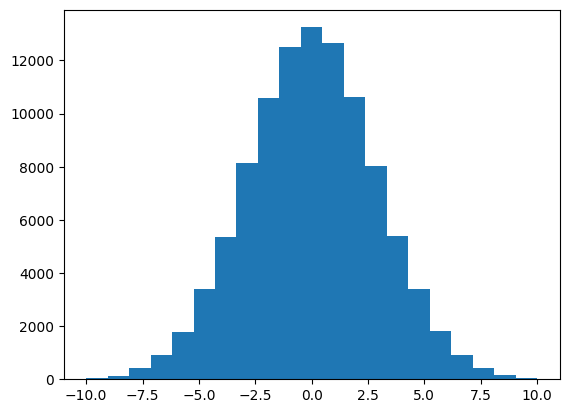

In [22]:
# Method 1
# # distr = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
# # print(distr[34])
# x = np.arange(1, 25)
# xU, xL = x + 0.5, x - 0.5 
# prob = ss.norm.cdf(xU, scale = 3) - ss.norm.cdf(xL, scale = 3)
# prob = prob / prob.sum() # normalize the probabilities so their sum is 1
# nums = np.random.choice(x, size = 10000, p = prob)
# plt.hist(nums, bins = len(x))

# Method 2
# import numpy as np
# from scipy.stats import truncnorm
# import matplotlib.pyplot as plt

# scale = 3.
# range = 10
# size = 100000

# X = truncnorm(a=-range/scale, b=+range/scale, scale=scale).rvs(size=size)
# X = X.round().astype(int)
# bins = 2 * range + 1
# plt.hist(X, bins)


In [4]:
# generate random numbers from N(0,1) # normal distribution for start time - 5am to 8pm
# type -> array of 1000 elements
data_normal = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
print(data_normal[50])

12.648167938789591


In [34]:
class Car(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self._max_battery = 100
        self._soc_thresh = 20
        self._charge_rate = 10
        self._in_queue = False
        self._in_garage = False
        self._is_charging = False
        self._is_travelling = False
        self._journey_complete = False

        # self._chargerate = None
        # self._loc_init = 
        # self._soc_init = 50 #initially 50 (+/- 10?). if over multiple days, use learnt value from prev day. If overnight charge, set to 100. write methods to handle cases later.
        # self.queue_time = self.chargerate * self. 
        self.soc = ss.poisson(45).rvs()
        self._pos_init = None #Urgent Fix soon
        self._active = False
        self.odometer = 0
        self._distance_goal = None
        # External 
        self.journey_urban = choice([True, False])
        self.start_time = ss.norm.rvs(size=1000,loc=12,scale=2, random_state = 42)
        # self._cp_entry = None
        # self._cp_exit = None
        # self._charge_start = None
        

    def select_journey_type(self):
        self._active == True
        if self.journey_urban == True:
            self._distance_goal = 50
        else:
             self._distance_goal = 100
        # print("Journey type selected: " + str(self._distance_goal))


    def travel(self):
        self._is_travelling = True
        # final_pos = (_pos_init + distance)
        self.odometer += 10
        self.soc -= 5
        if self.odometer == self._distance_goal:
            self._is_travelling = False
            self._journey_complete = True
        print("This vehicle travelled: " + str(self.odometer) + " distance units")
        # if self.soc < self._soc_thresh:
        #     self._is_travelling == False
        #     self.charge() #charge

    # def select_cp(self):
    #     # self._in_queue = True
    #     # # queue at shortest cp
    #     # self._chosen_cp_idx = np.argmin([
    #     #     len(cpoint.queue) for cpoint in self.model.cpoints])
    #     # self._chosen_cp = self.model.cpoint[self._chosen_cpoint_idx]
    #     self._in_queue = True

    
    def charge(self):
        self._is_charging = True
        # self._cp_exit = self.model._current_tick
        # self._chosen_cp.active_car = None
        # self.soc = self._max_battery
        # while self.soc < self._max_battery:
        #     self.soc += self._charge_rate
        #     if self.soc == self._max_battery:
        #         self._is_charging = False
        while self.soc < self._max_battery:
            self.soc += self._charge_rate
        self._is_charging = False
                

    def charge_overnight(self):
        if self._in_garage == True:
            self.soc = self._max_battery
    
    # def step(self):
    #     if (self._in_queue == False) & (self.model._current_tick >= self.entry_time):
    #         self.select_cp()
    #     elif isinstance(self.self._cp_entry, int):
    #         if self.model._current_tick - self._cp_entry == self.charge_time:
    #             self.travel()
    def step(self):
        # if self.model._current_tick >= self.start_time:
        self.select_journey_type()
        self.travel()
        if self.soc < self._soc_thresh:
            self._is_travelling == False
            self.charge() #charge
            self.travel()




class MainModel(Model):
    """Simulation Model with cars and charging points as two types of agents, interacting."""

    def __init__(self, no_cars, ticks):
        # super().__init__()
        # init with input args
        self.ticks = ticks
        self._current_tick = 1
        self.no_cars = no_cars
        # other key model attr 
        self.schedule = RandomActivation(self)
        # Populate model with agents
        self.cars = []
        for i in range(self.no_cars):
            car = Car(i,self)
            self.schedule.add(car)

        self.datacollector = DataCollector(
            model_reporters={'Cars Charged': get_cars_charged,
                             'Cars Activated': get_cars_active})
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self._current_tick += 1



In [35]:
ticks = 2400 # 3600 ticks = 3600 seconds = 1 hour
no_cars = 1
no_cpoints = 2
model = MainModel(ticks=ticks,
    no_cars=no_cars)
for i in range(ticks):
    model.step()

This vehicle travelled: 10 distance units
This vehicle travelled: 20 distance units
This vehicle travelled: 30 distance units
This vehicle travelled: 40 distance units
This vehicle travelled: 50 distance units
This vehicle travelled: 60 distance units
This vehicle travelled: 70 distance units
This vehicle travelled: 80 distance units
This vehicle travelled: 90 distance units
This vehicle travelled: 100 distance units
This vehicle travelled: 110 distance units
This vehicle travelled: 120 distance units
This vehicle travelled: 130 distance units
This vehicle travelled: 140 distance units
This vehicle travelled: 150 distance units
This vehicle travelled: 160 distance units
This vehicle travelled: 170 distance units
This vehicle travelled: 180 distance units
This vehicle travelled: 190 distance units
This vehicle travelled: 200 distance units
This vehicle travelled: 210 distance units
This vehicle travelled: 220 distance units
This vehicle travelled: 230 distance units
This vehicle travell

In [27]:
def get_cars_charged(model):
    cars_charged = [car._is_charging for car in model.cars]
    no_cars_charged = np.sum(cars_charged)
    return no_cars_charged

def get_cars_active(model):
    cars_active = [car._is_active for car in model.cars]
    no_cars_active = np.sum(cars_active)
    return no_cars_active

# def get_avg_queue_size(model):
#     queue_size = [len(counter.queue) for counter in model.counters]
#     avg_queue_size = np.mean(queue_size)
#     return avg_queue_size

# def get_avg_waiting_time(model):
#     cars_wait = [np.nan if car._cp_exit is None else
#                       car._cp_exit - car._cp_entry for car in model.cars]
#     avg_customer_wait = np.nanmean(cars_wait)
#     return avg_customer_wait

# def get_customers_served(model):
#     customers_served = [not(customer._service_exit is None) for customer in model.customers]     
#     no_customers_served = np.sum(customers_served)
#     return no_customers_served
# def get_customers_balked(model):
#     customers_arrived = [
#         customer._arrived for customer in model.customers]
#     # Customers who never joined a queue
#     customers_no_q = np.array([
#         customer._q_entry is None for customer in model.customers])
#     no_customers_balked = np.sum(customers_arrived * customers_no_q)
#     return no_customers_balked
# def get_avg_queue_size(model):
#     queue_size = [len(counter.queue) for counter in model.counters]
#     avg_queue_size = np.mean(queue_size)
#     return avg_queue_size
# def get_avg_waiting_time(model):
#     customers_wait = [np.nan if customer._q_exit is None else
#                       customer._q_exit - customer._q_entry for customer in model.customers]
#     avg_customer_wait = np.nanmean(customers_wait)
#     return avg_customer_wait
# def get_gross_margin(model):
#     return gross_margin_per_customer * get_customers_served(model)
# def get_operating_costs(model):
#     return cost_per_counter * no_counters
# def get_total_profit(model):
#     return get_gross_margin(model) - get_operating_costs(model)

In [28]:
run_stats = model.datacollector.get_model_vars_dataframe()

In [29]:
print(run_stats)

      Cars Charged  Cars Activated
0              0.0             0.0
1              0.0             0.0
2              0.0             0.0
3              0.0             0.0
4              0.0             0.0
...            ...             ...
2395           0.0             0.0
2396           0.0             0.0
2397           0.0             0.0
2398           0.0             0.0
2399           0.0             0.0

[2400 rows x 2 columns]


In [ ]:
run_stats = model.datacollector.get_model_vars_dataframe()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
fig.figure.set_figwidth(12)
fig.figure.set_figheight(16)
fig.suptitle(f'Simulations stats using {no_counters} counters', fontsize=20)
ax1.plot(run_stats[['Customers Arrived',
                'Customers Served',
                'Customers Balked',
               ]])
ax1.legend(['Customers Arrived',
            'Customers Served',
            'Customers Balked',
            ])
ax1.set_ylabel('Customers')
ax1.set_xlim(0)
ax1.set_ylim(0)
ax2.plot(run_stats['Average Queue Size'], color='red')
ax2.legend(['Average Queue Size'])
ax2.set_ylabel('Customers')
ax2.set_xlim(0)
ax2.set_ylim(0)
ax3.plot(run_stats['Average Waiting Time'], color='grey')
ax3.legend(['Average Waiting Time (across full hour)'])
ax3.set_ylabel('Seconds')
ax3.set_xlim(0)
ax3.set_ylim(0)
ax4.plot(run_stats[['Gross Margin',
                'Operating Costs',
                'Total Profit'
               ]])
ax4.legend(['Gross Margin',
            'Operating Costs',
            'Total Profit'
            ])
ax4.set_ylabel('Dollars')
ax4.set_xlim(0)
fig.show()